# Modeling Yelp Data

Paul Lim

## Libraries

In [304]:
# Main imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# sklearn
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import pipeline, feature_selection, decomposition
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import DBSCAN, AgglomerativeClustering, Birch
from sklearn.decomposition import PCA, NMF
from sklearn.metrics import silhouette_score

# from sklearn.naive_bayes import GaussianNB, MultinomialNB
# from sklearn.linear_model import LogisticRegression, SGDClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
# from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier

# NLP 
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy
import gensim
from gensim import models
from gensim.models import word2vec
import snowballstemmer

# Misc.
import re
import datetime
import time
import logging
import math

% matplotlib inline

sns.set_style("white")
sns.set_style('ticks')
sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})
sns.set_style({'legend.frameon': True})

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Running List of Functions/Classes

### Classes

In [280]:
class DataframeToSeriesTransformer(BaseEstimator, TransformerMixin):
        
    def __init__(self, col=None):
        self.col = col
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.col:
            print("DTST: ", X[self.col].shape)
            return X[self.col]
        else:
            return X
        
class SeparateFeaturesTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_cols=None, text_cols=None):
        self.num_cols = num_cols
        self.text_cols = text_cols
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.num_cols:
            print("SFT: ", X.loc[:, self.num_cols].shape)
            return X.loc[:, self.num_cols]
        elif self.text_cols:
            print("SFT: ", X.loc[:, self.text_cols].shape)
            return X.loc[:, self.text_cols]
        else:
            return X
        
class WilsonAverageTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_col=None, biz_list=None):
        self.num_col = num_col
        self.biz_list = biz_list
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.num_col and self.biz_list.all():
            scores = get_average_rating(X, self.biz_list)
            
            X_avg = pd.DataFrame({'average': scores})
            print("WAT: ", X_avg.shape)
            return X_avg
        else:
            return X
        
class CleanTextTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, text_col=None):
        self.text_col = text_col
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
#         NLP = spacy.load('en')
        stemmer = snowballstemmer.EnglishStemmer()
        stop = stopwords.words('english')
        stop_list = stemmer.stemWords(stop)
        stop_list = set(stop_list)
        stop = set(stop + list(stop_list))
        
        if self.text_col:
            df = pd.DataFrame()
            clean_review_list = []
            
            for review in X.loc[:, self.text_col]:
                clean_review = ''
                
                for word in TextBlob(review).words:
                    if word not in stop:
                        clean_review += word.lemmatize() + ' '
                        
#                 clean_review = NLP(clean_review)
                clean_review_list.append(clean_review)
                        
            df['clean_reviews'] = clean_review_list
            print("CTT: ", df.shape)
            return df
        else:
            return X
        
class DensifyTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = pd.DataFrame(X.toarray())
        print("DT: ", df.shape)
        return df
    
class SentimentTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_col=None):
        self.text_col = text_col
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.text_col:
            df = pd.DataFrame()
            sum_pol_list = []
            sum_sub_list = []

            for doc in X.loc[:, self.text_col]:
                sum_pol = 0
                sum_sub = 0
                doc_blob = TextBlob(doc)

                for sent in doc_blob.sentences:
                    sum_pol += sent.sentiment[0]
                    sum_sub += sent.sentiment[1]

                sum_pol_list.append(sum_pol)
                sum_sub_list.append(sum_sub)

            df['pol'] = sum_pol_list
            df['sub'] = sum_sub_list
            df['clean_reviews'] = X.loc[:, self.text_col] # Need to keep the clean reviews for the W2V transformer.
            print("ST: ", df.shape)
            return df
        else:
            return X

class Word2VecTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_col=None, w2v=None):
        self.text_col = text_col
        self.w2v = w2v
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.text_col:
            avg_w2v_list = []
            
            for review in X.loc[:, self.text_col]:
                avg_w2v = np.zeros(300)
                count = 0
                
                for word in review:
                    try:
                        avg_w2v += w2v.word_vec(word)
                        count += 1
                    except Exception:
                        continue

                avg_w2v_list.append(avg_w2v/count)
            df = pd.DataFrame(avg_w2v_list)
#             print(df.head())
            print("W2V: ", df.shape)
            return df
        else:
            return X
        
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        df = pd.DataFrame(X)
#         print(df.head())
        print("TDFT: ", df.shape)
        return df
        
class DropTextTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_col=None):
        self.text_col = text_col
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.text_col:
            df = X.drop(self.text_col, axis=1)
            print("DTT: ", df.shape)
            return df

### Functions

In [290]:
def confidence(pos, neg):
    '''
    Calculates the Wilson confidence where pos is the number of positive ratings
    and neg is the number of negative ratings.
    '''
    n = pos + neg
    
    if n == 0:
        return 0
    z = 1.96 # 95% confidence interval
    phat = float(pos) / n
    return (((phat + z*z/(2*n) - z * np.sqrt((phat*(1-phat)+z*z/(4*n))/n))/(1+z*z/n)))

def get_average_rating(df, biz_list):
    '''
    Compiles the list of average ratings for each business in biz_list.
    '''
    wils_list = []
    
    for biz in biz_list:
        ind_biz = df[df['name'] == biz]
        
        pos_count = 0
        neg_count = 0
        
        for rating in ind_biz['rating']:
            if rating > 3:
                pos_count += 1
            else:
                neg_count += 1
        
        wils_conf = confidence(pos_count, neg_count)
        wils_list.append(wils_conf)
    return wils_list

def sample_cluster(df, group_by_cols, size=5):
    sample_fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace=True), :]
    df = df.groupby(group_by_cols, as_index=False).apply(sample_fn)
    
    return df

def get_metrics(pipe, model, df_orig):
    df_transformed = pipe.fit_transform(df_orig)
#     print(df_transformed[0])
    pred = model.fit_predict(df_transformed)
    print("Number of Clusters: ", len(np.unique(pred)))
    print("Silhouette Coefficient: %0.3f" % silhouette_score(df_transformed, model.labels_))
    return df_transformed, pred

def model_metrics(model_dict, pipe, df):

    model_dfs = {}
    for name, model in model_dict.items():
        print(name)
        temp_df, temp_score = get_metrics(pipe, model, df)
        model_dfs[name] = [temp_df, temp_score]
    return model_dfs

## Data Preprocessing

### Load in data

In [4]:
df_init = joblib.load('../data/df_tot')

### Reorder columns

In [5]:
df_init = df_init[['name', 'rating' ,'reviews']]

### Change rating to int type

In [6]:
df_init['rating'] = df_init['rating'].apply(lambda x: int(x))

### Create holdout set

In [7]:
df_shuffled = df_init.sample(frac=1)

holdout_size = round(len(df_shuffled)*0.2)

df_holdout = df_shuffled.iloc[:holdout_size, :]
df_model = df_shuffled.iloc[holdout_size:, :]

print("Holdout Size: ", len(df_holdout))
print("CV Size: ", len(df_model))

Holdout Size:  40939
CV Size:  163757


### Sort the dataframe for cross-validation

In [8]:
df_model = df_model.sort()

/Users/plim0793/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  if __name__ == '__main__':


### Create transformers for splitting text and num columns

In [74]:
t = SeparateFeatures(text_cols=['reviews'])
n = SeparateFeatures(num_cols=['rating'])

print(t.transform(df_model).head())
print(n.transform(df_model).head())

                                             reviews
1  A pretty hipster, modern spacious place to do ...
2  Great place to grab a coffee and you can get t...
3  Coffee is amazing! Overpriced as usual. There'...
4  Big time coffee lover. First time customer and...
5  Cool vibes abound in this warehouse-style open...
   rating
1       4
2       5
3       4
4       4
5       5


In [11]:
t.transform(df_model).shape
n.transform(df_model).shape

(163757, 3)

### Create transformer for averaging ratings for each business (may not need this since I might not average across the each business)

#### Get Wilson average for one business

In [12]:
one_biz = df_model[df_model['name'] == '0_FourBarrelCoffee']

In [13]:
pos_count = 0
neg_count = 0

for rating in one_biz['rating']:
    if rating > 3:
        pos_count += 1
    else:
        neg_count += 1
        
wil_conf = confidence(pos_count, neg_count)

#### Generalize to all businesses

In [14]:
biz_list = df_model['name'].unique()

In [15]:
wils_scores = get_average_rating(df_model, biz_list)

#### Create the transformer class

In [16]:
wat = WilsonAverageTransformer(num_col='rating', biz_list=biz_list)

In [17]:
wat.transform(df_model)

,average
0,0.717901
1,0.858098
2,0.795028
3,0.732776
4,0.811068
5,0.790576
6,0.719914
7,0.891296
8,0.564857
9,0.922868


### Create a transformer for preprocessing the reviews

#### Get the lemmatized review for just one review

In [18]:
one_review = df_model.iloc[0, 2]

In [19]:
nlp = spacy.load('en')

In [20]:
sample_doc = nlp(one_review)

In [21]:
clean_doc = ''
for word in sample_doc:
    if word.is_stop == False:
        clean_doc += word.lemma_ + ' '
clean_doc = nlp(clean_doc)

In [22]:
for sent in clean_doc.sents:
    print(sent)

hipster coffee galore ! happen good ol cup joe ?
need expensive ?
line long , figure coffee mind blow .
impressed . enjoy !


#### Generalize to all reviews

In [23]:
test_df = df_model.iloc[:100, :]

In [24]:
ct = CleanText('reviews')

test_ct = ct.transform(test_df)

In [25]:
tf = TfidfVectorizer()

tf_t = tf.fit_transform(test_ct.clean_reviews)

In [26]:
tf_t.todense()

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [28]:
print(test_ct.clean_reviews[0])

hipster coffee galore ! happen good ol cup joe ? need expensive ? line long , figure coffee mind blow . impressed . enjoy ! 


## Build the Pipeline

#### Set a smaller test dataframe (10 samples from each business)

In [9]:
df_test = sample_cluster(df_model, ['name'], size=5)

In [10]:
df_test.shape

(4155, 3)

#### PCA pipeline

In [303]:
pipe_pca = Pipeline([
                            ('combined_features', FeatureUnion([

                                ('num_feat', SeparateFeaturesTransformer(num_cols=['rating'])),
                                ('text_feat', Pipeline([

                                    ('split_text', SeparateFeaturesTransformer(text_cols=['reviews'])),
                                    ('clean', CleanTextTransformer('reviews')),
                                    ('combine_text', FeatureUnion([
                                            
                                        ('sentiment_analysis', SentimentTransformer(text_col='clean_reviews')),
                                        ('vectorize', Pipeline([

                                            ('to_series', DataframeToSeriesTransformer(col='clean_reviews')),
                                            ('tfidf', TfidfVectorizer(stop_words="english",
                                                                      token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b",
                                                                      min_df=10)),
                                            ('densify', DensifyTransformer()),
                                            ('pca', PCA(n_components=3))
                                                            ]))
                                                                ])),
                                    ('to_df', ToDataFrameTransformer()),
                                    ('drop_text', DropTextTransformer(text_col=2))
                                                        ]))
                                                            ]))
                            ])

#### NMF pipeline

In [305]:
pipe_nmf = Pipeline([
                            ('combined_features', FeatureUnion([

                                ('num_feat', SeparateFeaturesTransformer(num_cols=['rating'])),
                                ('text_feat', Pipeline([

                                    ('split_text', SeparateFeaturesTransformer(text_cols=['reviews'])),
                                    ('clean', CleanTextTransformer('reviews')),
                                    ('combine_text', FeatureUnion([
                                            
                                        ('sentiment_analysis', SentimentTransformer(text_col='clean_reviews')),
                                        ('vectorize', Pipeline([

                                            ('to_series', DataframeToSeriesTransformer(col='clean_reviews')),
                                            ('tfidf', TfidfVectorizer(stop_words="english",
                                                                      token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b",
                                                                      min_df=10)),
                                            ('densify', DensifyTransformer()),
                                            ('nmf', NMF(n_components=3))
                                                            ]))
                                                                ])),
                                    ('to_df', ToDataFrameTransformer()),
                                    ('drop_text', DropTextTransformer(text_col=2))
                                                        ]))
                                                            ]))
                            ])

#### Use the Google word2vec model in place of the tf-idf and PCA steps

In [285]:
# ONLY RUN ONCE AT THE START OF THE KERNEL
# w2v = models.KeyedVectors.load_word2vec_format("~/Documents/GoogleNews-vectors-negative300.bin.gz",binary=True)

2017-05-26 10:26:24,311 : INFO : loading projection weights from ~/Documents/GoogleNews-vectors-negative300.bin.gz
2017-05-26 10:29:06,505 : INFO : loaded (3000000, 300) matrix from ~/Documents/GoogleNews-vectors-negative300.bin.gz


In [306]:
pipe_w2v = Pipeline([
                                ('combined_features', FeatureUnion([

                                    ('num_feat', SeparateFeaturesTransformer(num_cols=['rating'])),
                                    ('text_feat', Pipeline([

                                        ('split_text', SeparateFeaturesTransformer(text_cols=['reviews'])),
                                        ('clean', CleanTextTransformer('reviews')),
                                        ('sentiment', SentimentTransformer(text_col='clean_reviews')),
                                        ('vectorize', Word2VecTransformer(text_col='clean_reviews', w2v=w2v))
                                                            ]))
                                                                    ]))
                                ])

### In order to take a closer look at the text processing steps, a smaller pipeline will be created

#### Set the text processing steps

In [12]:
text_processing = Pipeline([
                ('clean', CleanTextTransformer('reviews')),
                ('to_series', DataframeToSeriesTransformer(col='clean_reviews')),
                ('tfidf', TfidfVectorizer(stop_words="english",
                                          token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b",
                                          min_df=10)),
                ('densify', DensifyTransformer())
            ])

In [13]:
tp = text_processing.fit_transform(df_test)
tp.shape

(4155, 2163)

#### Run PCA with 2 latent features

In [14]:
pca = PCA(n_components=2)

In [15]:
tpm = pca.fit_transform(tp)

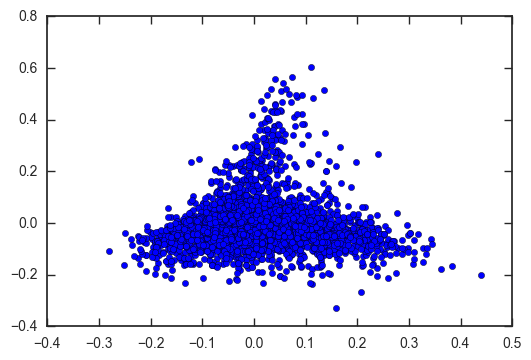

In [16]:
plt.scatter(tpm[:,0], tpm[:,1])

In [17]:
print(pca.explained_variance_ratio_)

[ 0.00933844  0.00853894]


#### Try various numbers of latent features

In [20]:
pca_range = [i for i in range(40)]
pca_variances_cum = []

for num in pca_range:
    pca_obj = PCA(n_components=num)
    pca_fit = pca_obj.fit_transform(tp)
    
    pca_variances_cum.append(sum(pca_obj.explained_variance_ratio_))

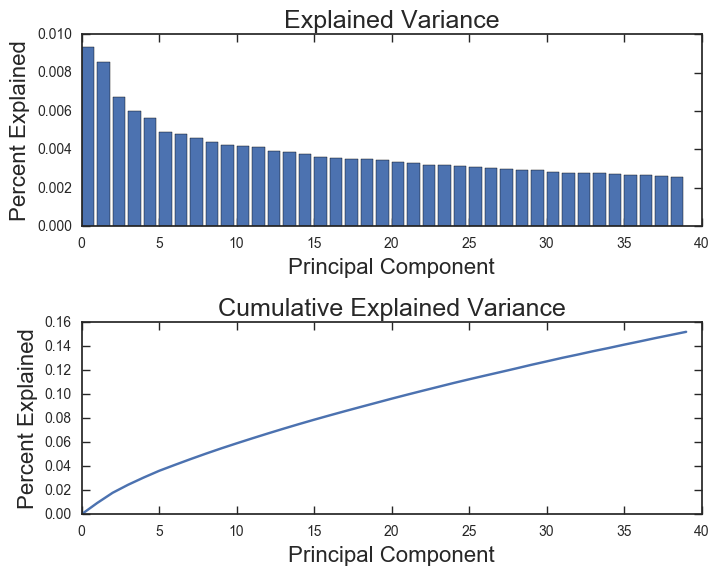

In [21]:
fig, ax = plt.subplots(2,1, figsize=(8,6))

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

# Plot of explained variance
ax1 = ax[0]
ax1.bar([x for x in range(len(pca_obj.explained_variance_ratio_))],pca_obj.explained_variance_ratio_)

ax1.set_title("Explained Variance", size=18)
ax1.set_ylabel("Percent Explained", size=16)
ax1.set_xlabel("Principal Component", size=16)

# Plot of cumulative explained variance
ax2 = ax[1]
ax2.plot([x for x in range(len(pca_variances_cum))], pca_variances_cum)

ax2.set_title("Cumulative Explained Variance", size=18)
ax2.set_ylabel("Percent Explained", size=16)
ax2.set_xlabel("Principal Component", size=16)

## Gauge how the PCA pipeline is by testing on DB Scan

In [150]:
db = DBSCAN(eps=0.5,
            min_samples=10,
            metric='euclidean')

In [310]:
pca_arr, pred_pca = get_metrics(pipe_pca, db, df_test)

SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2163)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.681


## Gauge how the NMF pipeline performs on DB Scan

In [309]:
nmf_arr, pred_nmf = get_metrics(pipe_nmf, db, df_test)

SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2163)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.737


## Gauge how the W2V pipeline performs on DB Scan

In [308]:
w2v_arr, pred_w2v = get_metrics(pipe_w2v, db, df_test)

SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
W2V:  (4155, 300)
Number of Clusters:  6
Silhouette Coefficient: 0.768


## Try other clustering algorithms

In [288]:
model_dict = {
    "agg": AgglomerativeClustering(n_clusters=5,
                                   affinity="cosine",
                                   linkage="complete"),
    "birch": Birch(threshold=0.5,
                   n_clusters=5,
                   branching_factor=50),
    "db": DBSCAN(eps=0.5,
                 min_samples=10,
                 metric="euclidean")
}

### Test on PCA pipeline

In [311]:
model_metrics_dict_PCA = model_metrics(model_dict, pipe_pca, df_test)

birch
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2163)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.681
agg
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2163)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.533
db
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2163)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.681


### Test on NMF pipeline

In [312]:
model_metrics_dict_NMF = model_metrics(model_dict, pipe_nmf, df_test)

birch
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2163)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.737
agg
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2163)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.533
db
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
DTST:  (4155,)
DT:  (4155, 2163)
TDFT:  (4155, 6)
DTT:  (4155, 5)
Number of Clusters:  5
Silhouette Coefficient: 0.737


### Test on W2V pipeline

In [313]:
model_metrics_dict_W2V = model_metrics(model_dict, pipe_w2v, df_test)

birch
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
W2V:  (4155, 300)
Number of Clusters:  4


/Users/plim0793/anaconda/lib/python3.5/site-packages/sklearn/cluster/birch.py:602: UserWarning: Number of subclusters found (4) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters))


Silhouette Coefficient: 0.652
agg
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
W2V:  (4155, 300)
Number of Clusters:  5
Silhouette Coefficient: 0.615
db
SFT:  (4155, 1)
SFT:  (4155, 1)
CTT:  (4155, 1)
ST:  (4155, 3)
W2V:  (4155, 300)
Number of Clusters:  6
Silhouette Coefficient: 0.768


### Append the predicted clusters to the dataframe

In [123]:
df_test['baseline_cluster'] = pred_bl

In [124]:
# Save the df_test so that the code doesn't have to be rerun each time
joblib.dump(df_test, '../data/df_test')

['../data/df_test']

In [125]:
grouped_df_test = df_test.groupby(['baseline_cluster'], as_index=False)

### Randomly draw a subset of reviews from each cluster and look at them individually

In [126]:
sampled_df_bl = sample_cluster(df_test, ['baseline_cluster'], size=5)

In [28]:
for i,doc in enumerate(sampled_df['reviews']):
    print("Document #: ", i)
    print(doc)

Document #:  0
Best coffee in Cole Valley.  Chairs outside.  Friendly staff.It's kind of small and awkward seating inside, so this is mostlya place to grab coffee and go.But they have nice chairs and tables outside so you can havea nice view of whatever delivery truck is parked in front ;)LIfe in the city; it's still nice.
Document #:  1
Overall it's a 3.5 star so just bumped to 4 stars for now.I've been a fan of Project Juice even since I did my first juice cleanse in April. I got my juice cleanse pack in the Mission store, daily drink at the FiDi store if I feel like to. Project Juice Test Kitchen opened last Saturday and I saw the promotion on Instagram -- get a smoothie or juice or bowl and show the staff the IG photo to receive a free kombucha juice! I got the classic acai bowl and swizz beetz kombucha juice. Acai bowl was yummy dessert, swizz beetz kombucha was better than I expected, I guess it was because the beets so it made the drink sweeter than regular kombucha. However it 

In [127]:
https://www.yelp.com/user_details?userid=FTfr7IJurqo_Ika3NoZ-Kw